# Question 2 

We are asked to implement a naive Bayes Classifier.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap as colors
from matplotlib.patches import Ellipse

In [ ]:
train_dataset_path = "/content/gdrive/MyDrive/Dataset for PRML PA1/Dataset2/train_8.csv"
test_dataset_path = "/content/gdrive/MyDrive/Dataset for PRML PA1/Dataset2/test_8.csv"

train_dataset = pd.read_csv(train_dataset_path)
test_dataset = pd.read_csv(test_dataset_path)

train_X = train_dataset.iloc[:, :2].values
train_Y = train_dataset.iloc[:, 2].values

test_X = test_dataset.iloc[:, :2].values
test_Y = test_dataset.iloc[:, 2].values

# Adding biases maybe?

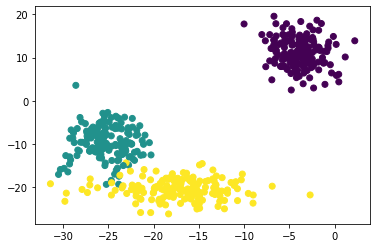

In [ ]:
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, cmap='viridis')

### Helper functions

Plotting of covariance ellipse code has been taken from [StackOverflow](https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals/12321306#12321306). 

In [ ]:
color_map_l = colors(['navajowhite', 'skyblue', 'violet'])
color_map_b = colors(['orange', 'dodgerblue', 'purple'])

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip


def getPlotWithBoundary(train_X, pred, knn, p):
  x1_min, x1_max = train_X[:, 0].min() - 1, train_X[:,0].max() + 1
  x2_min, x2_max = train_X[:, 1].min() - 1, train_X[:,1].max() + 1
  xx, yy = np.meshgrid(np.arange(x1_min, x1_max, p), np.arange(x2_min, x2_max, p))
  d_train_X = np.c_[xx.ravel(),yy.ravel()]
  # d_train_X = np.insert(d_train_X, 0, 1, axis=1)
  pred_decision_boundary = knn.predict(d_train_X)
  pred_decision_boundary = pred_decision_boundary.reshape(xx.shape)
  plt.contourf(xx, yy, pred_decision_boundary, cmap=color_map_l)
  plt.scatter(train_X[:, 0], train_X[:, 1], c=pred, cmap=color_map_b)
  classes = np.unique(pred_decision_boundary)
  color_map_ellipse = ['darkgoldenrod', 'blue', 'black']
  for label in classes:
    plot_point_cov(knn.class_items[label], nstd=1,color=color_map_ellipse[int(label)], fill=False)
    plot_point_cov(knn.class_items[label], nstd=2,color=color_map_ellipse[int(label)], fill=False)
    plot_point_cov(knn.class_items[label], nstd=3,color=color_map_ellipse[int(label)], fill=False)

def getConfusionMatrix(pred, test_Y):
  k = max(test_Y)+1
  conf_mat = np.zeros((k,k))
  for i in range(len(test_Y)):
    conf_mat[int(pred[i])][test_Y[i]]+=1
  return conf_mat
# Accuracy
def getAccuracy(conf_mat):
  return (np.trace(conf_mat)/np.sum(conf_mat))*100

def show_conf_mat(conf_mat, title):
  tick_label = ['',1, 2, 3, '']
  fig, (ax) = plt.subplots(ncols=1, figsize=(10, 5))
  ax.set_title('Confusion Matrix for ' + title + ' dataset')
  ax.set_xlabel('Target Class')
  ax.set_ylabel('Output Class')
  new_mat = []
  bottom = []
  temp = []
  for i in range(conf_mat.shape[1]):
    for j in range(conf_mat.shape[0]):
      c = (conf_mat[j][i]/np.sum(conf_mat))*100
      temp.append(c)
    tot = np.sum(conf_mat[i])
    p = (conf_mat[i][i]/tot)*100
    temp.append(p)
    new_mat.append(temp)
    temp = []
    tot = np.sum(conf_mat[:,i])
    p = (conf_mat[i][i]/tot)*100
    bottom.append(p)
  bottom.append(getAccuracy(conf_mat))
  new_mat.append(bottom)
  new_mat = np.round(new_mat, decimals=2)
  ax.matshow(new_mat, cmap='Wistia')
  tot = np.sum(conf_mat)
  for i in range(conf_mat.shape[1]):
    for j in range(conf_mat.shape[0]):
      c = conf_mat[j][i]
      ax.text(i, j, str(c),fontsize=18, va='center', ha='center')
      ax.text(i, j+0.25, str(np.round((c/tot)*100, decimals=2)) + "%", fontsize=10, va='center', ha='center')
  for i in range(conf_mat.shape[0]):
    c = new_mat[conf_mat.shape[0]][i]
    ax.text(conf_mat.shape[0], i, str(c),color = 'green', fontsize=18, va='center', ha='center')
    ax.text(conf_mat.shape[0], i+0.25, str(np.round(100-c, decimals=2)) + "%", color = 'red', fontsize=10, va='center', ha='center')
    c = new_mat[i][conf_mat.shape[0]]
    ax.text(i, conf_mat.shape[0], str(c),color = 'green', fontsize=16, va='center', ha='center')
    ax.text(i, conf_mat.shape[0]+0.25, str(np.round(100-c, decimals=2)) + "%", color = 'red', fontsize=10, va='center', ha='center')
  ax.text(conf_mat.shape[0], conf_mat.shape[0], str(new_mat[conf_mat.shape[0]][conf_mat.shape[0]]), color = 'green', fontsize=16, va='center', ha='center')
  ax.text(conf_mat.shape[0], conf_mat.shape[0]+0.25, str(np.round(100-new_mat[conf_mat.shape[0]][conf_mat.shape[0]], decimals=2)), color = 'red', fontsize=10, va='center', ha='center')
  ax.set_xticklabels(tick_label)
  ax.set_yticklabels(tick_label)
  plt.show()



A Naive Bayes Classifier works as follows:

$$P(class | X_0, X_1) = P(X_0 | class) * P(X_1, class) * P(class)$$

The following code is a base class used for all the remaining sub classes.

In [ ]:
class NaiveBayesClassifier:
  def __init__(self):
    pass
  def fit(self, X, Y):
    self.separate_class(X, Y)
    self.class_probability(X, Y)
    self.cal_mean_std(X, Y)
    self.num_data = X.shape[0]

  def predict(self, X):
    pass

  def multivariate_normal_pdf(self, x, mu, sigma):
      k = len(x)
      det = np.linalg.det(sigma)
      inv = np.linalg.inv(sigma)
      norm_const = 1.0 / np.sqrt((2*np.pi)**k * det)
      exponent = -0.5 * (x - mu).T.dot(inv).dot((x - mu))
      return norm_const * np.exp(exponent)

  def cal_mean_std(self, X, Y):
    self.mean = {}
    self.cov = {}
    self.std = {}
    for label in self.class_items:
      self.mean[label] = np.mean(self.class_items[label], axis=0)
      self.cov[label] = np.cov(self.class_items[label], rowvar=False)
      self.std[label] = np.std(self.class_items[label], axis=0)
  def separate_class(self, X, Y):
    self.class_items = {}
    for row, label in zip(X, Y):
      if self.class_items.get(label) == None:
        self.class_items[label] = []
      self.class_items[label].append(row)
    for label in self.class_items:
      self.class_items[label] = np.array(self.class_items[label])
    self.num_classes = len(self.class_items)
    self.classes = list(self.class_items.keys())
  def class_probability(self, X, Y):
    self.class_probs = {}
    for label in self.class_items:
      self.class_probs[label] = len(self.class_items[label])/len(X)

## (a) Naive Bayes Classifier with Covariance = I

In [ ]:
class NaiveBayesClassifierIndependent(NaiveBayesClassifier):
  def __init__(self):
    pass
  def calc_prob(self, row, label):
    return self.multivariate_normal_pdf(row, self.mean[label], np.identity(self.class_items[label].shape[1]))
  def predict(self, X):
    y_pred = np.zeros(X.shape[0])
    for index, row in enumerate(X):
      probs = np.zeros(self.num_classes)
      for i, label in enumerate(self.class_items):
        probs[i] = self.class_probs[label] * self.calc_prob(row, label)
      y_pred[index] = self.classes[np.argmax(probs)]
    return y_pred
  

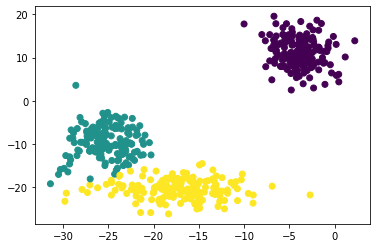

In [ ]:
nbc = NaiveBayesClassifierIndependent()
nbc.fit(train_X, train_Y)
preds = nbc.predict(train_X)
plt.scatter(train_X[:, 0], train_X[:, 1], c=preds, cmap='viridis')

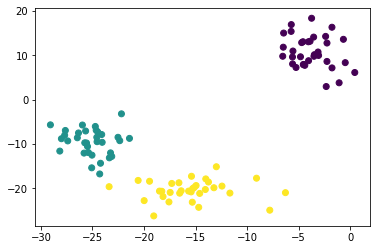

In [ ]:
preds = nbc.predict(test_X)
plt.scatter(test_X[:, 0], test_X[:, 1], c=preds, cmap='viridis')

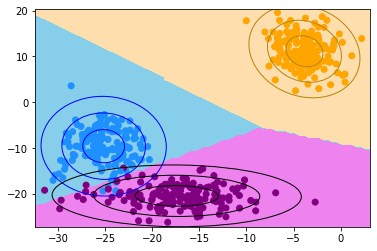

In [ ]:
preds = nbc.predict(train_X)
getPlotWithBoundary(train_X, train_Y, nbc, 0.5)

Training data:
98.6


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


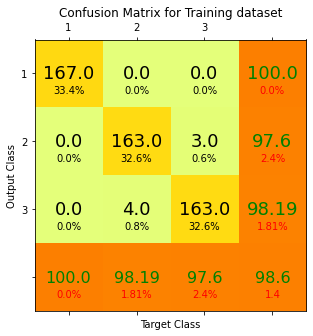

In [ ]:
conf_mat = getConfusionMatrix(preds, train_Y)
accuracy = getAccuracy(conf_mat)
print("Training data:")
print(accuracy)
show_conf_mat(conf_mat, "Training")

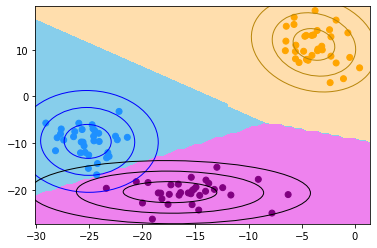

In [ ]:
preds = nbc.predict(test_X)
getPlotWithBoundary(test_X, test_Y, nbc, 0.5)
plt.show()

Test data:
100.0


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


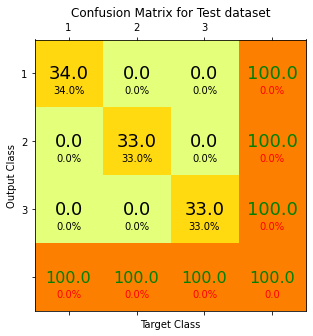

In [ ]:
conf_mat = getConfusionMatrix(preds, test_Y)
accuracy = getAccuracy(conf_mat)
print("Test data:")
print(accuracy)
show_conf_mat(conf_mat, "Test")

## (b) The same for dataset 3

In [ ]:
train_dataset_path_3 = "/content/gdrive/MyDrive/Dataset for PRML PA1/Dataset3/train_8.csv"
test_dataset_path_3 = "/content/gdrive/MyDrive/Dataset for PRML PA1/Dataset3/test_8.csv"

train_dataset = pd.read_csv(train_dataset_path_3)
test_dataset = pd.read_csv(test_dataset_path_3)

train_X_3 = train_dataset.iloc[:, :2].values
train_Y_3 = train_dataset.iloc[:, 2].values

test_X_3 = test_dataset.iloc[:, :2].values
test_Y_3 = test_dataset.iloc[:, 2].values

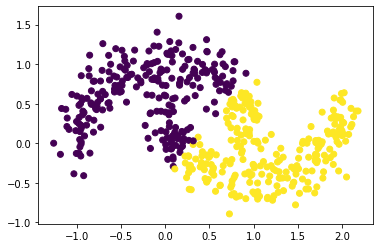

In [ ]:
nbc = NaiveBayesClassifierIndependent()
nbc.fit(train_X_3, train_Y_3)
preds = nbc.predict(train_X_3)
plt.scatter(train_X_3[:, 0], train_X_3[:, 1], c=preds, cmap='viridis')

In [ ]:
(train_Y_3 == preds).sum()

389

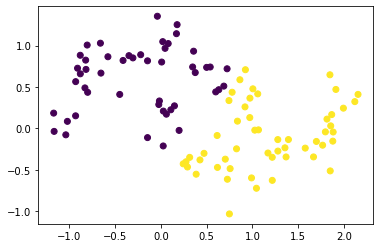

In [ ]:
preds = nbc.predict(test_X_3)
plt.scatter(test_X_3[:, 0], test_X_3[:, 1], c=preds, cmap='viridis')

In [ ]:
(test_Y_3 == preds).sum()

78

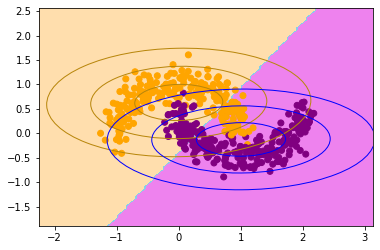

In [ ]:
preds = nbc.predict(train_X_3)
getPlotWithBoundary(train_X_3, train_Y_3, nbc, 0.05)

Training data:
77.8


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


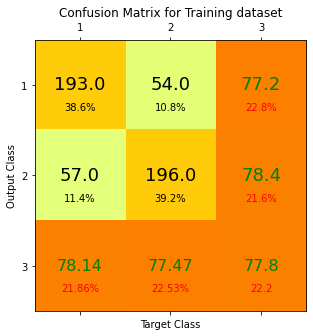

In [ ]:
conf_mat = getConfusionMatrix(preds, train_Y_3)
accuracy = getAccuracy(conf_mat)
print("Training data:")
print(accuracy)
show_conf_mat(conf_mat, "Training")

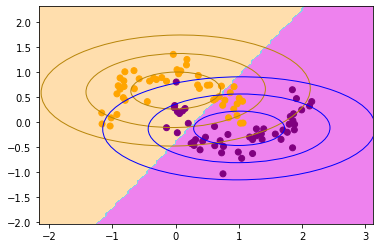

In [ ]:
preds = nbc.predict(test_X_3)
getPlotWithBoundary(test_X_3, test_Y_3, nbc, 0.05)

Training data:
78.0


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


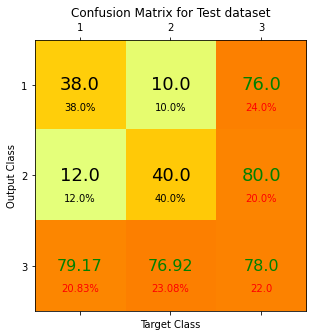

In [ ]:
conf_mat = getConfusionMatrix(preds, test_Y_3)
accuracy = getAccuracy(conf_mat)
print("Training data:")
print(accuracy)
show_conf_mat(conf_mat, "Test")

## (c) When the covariance is the same

Here we will be taking the average of the covariance matrices of each of the classes.



In [ ]:
class NaiveBayesClassifierEqual(NaiveBayesClassifier):
  def predict(self, X):
    y_pred = np.zeros(X.shape[0])
    all_cov = np.zeros((X.shape[1], X.shape[1]))
    for label in self.class_items:
      all_cov += (self.cov[label])*(len(self.class_items[label])-1)
    all_cov/=(self.num_data - self.num_classes)
    print(all_cov)
    for index, row in enumerate(X):
      probs = np.zeros(self.num_classes)
      for i, label in enumerate(self.class_items):
        probs[i] = self.class_probs[label] * self.multivariate_normal_pdf(row, self.mean[label], all_cov)
      y_pred[index] = self.classes[np.argmax(probs)]
    return y_pred

[[ 9.36386204 -0.48378803]
 [-0.48378803  9.91368071]]


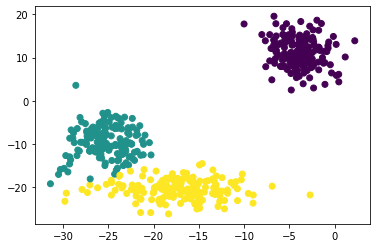

In [ ]:
nbc = NaiveBayesClassifierEqual()
nbc.fit(train_X, train_Y)
preds = nbc.predict(train_X)
plt.scatter(train_X[:, 0], train_X[:, 1], c=preds, cmap='viridis')

[[ 9.36386204 -0.48378803]
 [-0.48378803  9.91368071]]


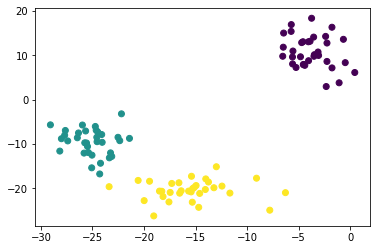

In [ ]:
preds = nbc.predict(test_X)
plt.scatter(test_X[:, 0], test_X[:, 1], c=preds, cmap='viridis')

[[ 9.36386204 -0.48378803]
 [-0.48378803  9.91368071]]
[[ 9.36386204 -0.48378803]
 [-0.48378803  9.91368071]]


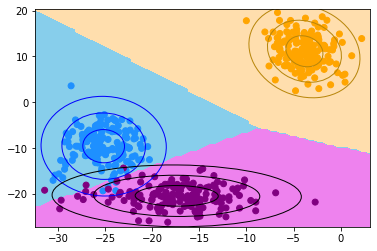

In [ ]:
preds = nbc.predict(train_X)
getPlotWithBoundary(train_X, train_Y, nbc, 0.5)

Training data:
98.6


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


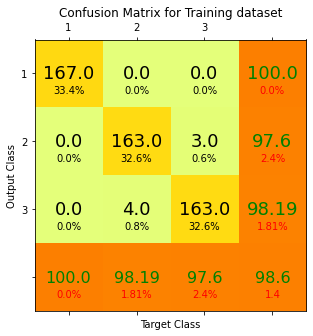

In [ ]:
conf_mat = getConfusionMatrix(preds, train_Y)
accuracy = getAccuracy(conf_mat)
print("Training data:")
print(accuracy)
show_conf_mat(conf_mat, "Training")

[[ 9.36386204 -0.48378803]
 [-0.48378803  9.91368071]]
[[ 9.36386204 -0.48378803]
 [-0.48378803  9.91368071]]


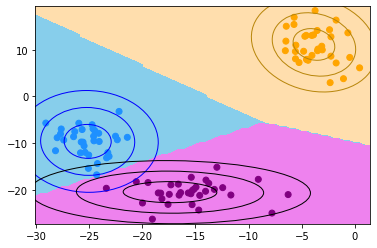

In [ ]:
preds = nbc.predict(test_X)
getPlotWithBoundary(test_X, test_Y, nbc, 0.5)

Test data:
100.0


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


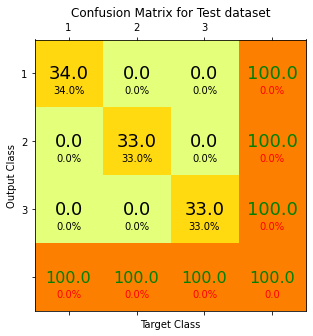

In [ ]:
conf_mat = getConfusionMatrix(preds, test_Y)
accuracy = getAccuracy(conf_mat)
print("Test data:")
print(accuracy)
show_conf_mat(conf_mat, "Test")

## (d) The same for dataset 3

[[0.51103746 0.00718088]
 [0.00718088 0.12756583]]


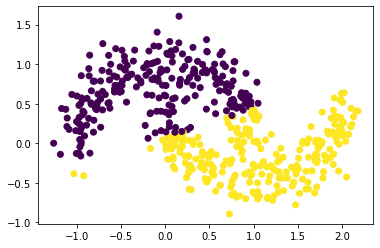

In [ ]:
nbc = NaiveBayesClassifierEqual()
nbc.fit(train_X_3, train_Y_3)
preds = nbc.predict(train_X_3)
plt.scatter(train_X_3[:, 0], train_X_3[:, 1], c=preds, cmap='viridis')

[[0.51103746 0.00718088]
 [0.00718088 0.12756583]]


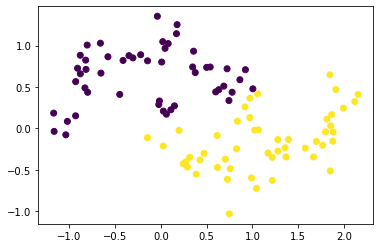

In [ ]:
preds = nbc.predict(test_X_3)
plt.scatter(test_X_3[:, 0], test_X_3[:, 1], c=preds, cmap='viridis')

[[0.51103746 0.00718088]
 [0.00718088 0.12756583]]
[[0.51103746 0.00718088]
 [0.00718088 0.12756583]]


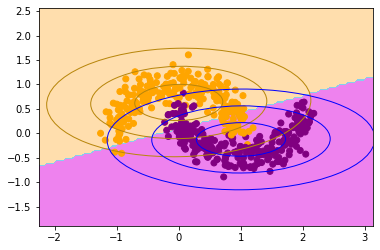

In [ ]:
preds = nbc.predict(train_X_3)
getPlotWithBoundary(train_X_3, train_Y_3, nbc, 0.05)

Training data:
87.4


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


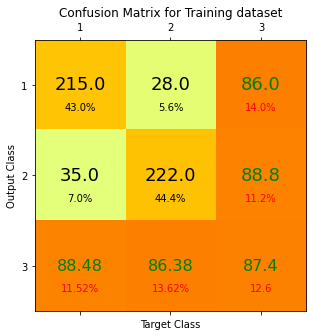

In [ ]:
conf_mat = getConfusionMatrix(preds, train_Y_3)
accuracy = getAccuracy(conf_mat)
print("Training data:")
print(accuracy)
show_conf_mat(conf_mat, "Training")

[[0.51103746 0.00718088]
 [0.00718088 0.12756583]]
[[0.51103746 0.00718088]
 [0.00718088 0.12756583]]


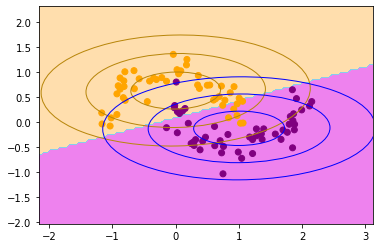

In [ ]:
preds = nbc.predict(test_X_3)
getPlotWithBoundary(test_X_3, test_Y_3, nbc, 0.05)

Training data:
86.0


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


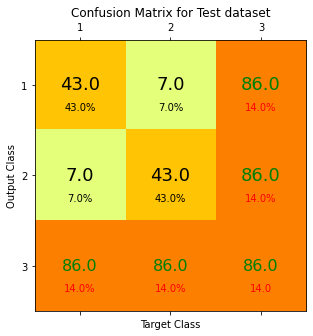

In [ ]:
conf_mat = getConfusionMatrix(preds, test_Y_3)
accuracy = getAccuracy(conf_mat)
print("Training data:")
print(accuracy)
show_conf_mat(conf_mat, "Test")

## (e) Assuming the covariance matrix is different for all three classes


In [ ]:
class NaiveBayesClassifierDiff(NaiveBayesClassifier):
  def predict(self, X):
    y_pred = np.zeros(X.shape[0])
    for index, row in enumerate(X):
      probs = np.zeros(self.num_classes)
      for i, label in enumerate(self.class_items):
        probs[i] = self.class_probs[label] * self.multivariate_normal_pdf(row, self.mean[label], self.cov[label])
      y_pred[index] = self.classes[np.argmax(probs)]
    return y_pred

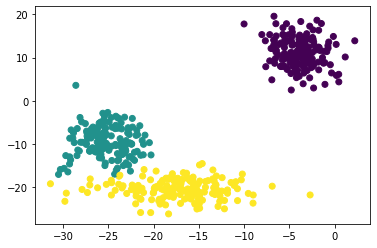

In [ ]:
nbc = NaiveBayesClassifierDiff()
nbc.fit(train_X, train_Y)
preds = nbc.predict(train_X)
plt.scatter(train_X[:, 0], train_X[:, 1], c=preds, cmap='viridis')

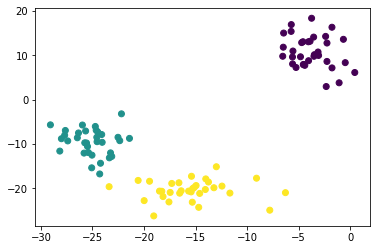

In [ ]:
preds = nbc.predict(test_X)
plt.scatter(test_X[:, 0], test_X[:, 1], c=preds, cmap='viridis')

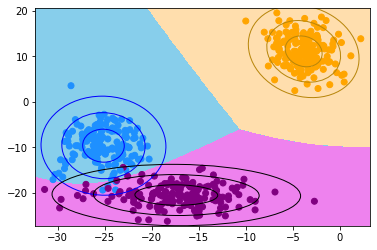

In [ ]:
preds = nbc.predict(train_X)
getPlotWithBoundary(train_X, train_Y, nbc, 0.1)

Training data:
98.8


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


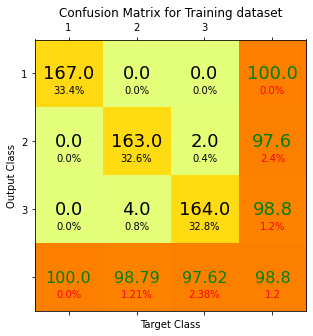

In [ ]:
conf_mat = getConfusionMatrix(preds, train_Y)
accuracy = getAccuracy(conf_mat)
print("Training data:")
print(accuracy)
show_conf_mat(conf_mat, "Training")

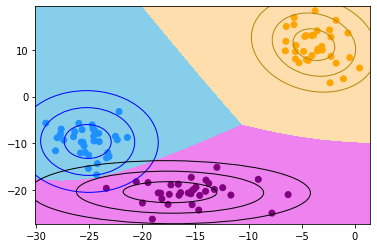

In [ ]:
preds = nbc.predict(test_X)
getPlotWithBoundary(test_X, test_Y, nbc, 0.05)

Test data:
100.0


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


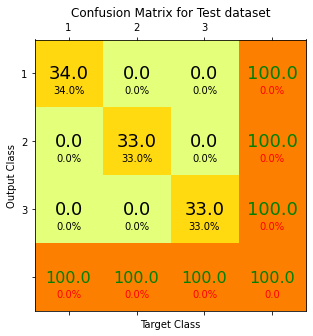

In [ ]:
conf_mat = getConfusionMatrix(preds, test_Y)
accuracy = getAccuracy(conf_mat)
print("Test data:")
print(accuracy)
show_conf_mat(conf_mat, "Test")

## (f) The same for dataset 3

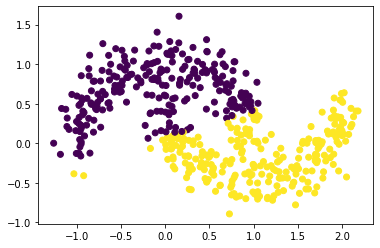

In [ ]:
nbc = NaiveBayesClassifierDiff()
nbc.fit(train_X_3, train_Y_3)
preds = nbc.predict(train_X_3)
plt.scatter(train_X_3[:, 0], train_X_3[:, 1], c=preds, cmap='viridis')

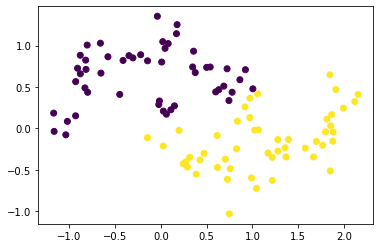

In [ ]:
preds = nbc.predict(test_X_3)
plt.scatter(test_X_3[:, 0], test_X_3[:, 1], c=preds, cmap='viridis')

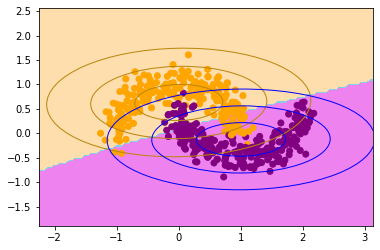

In [ ]:
preds = nbc.predict(train_X_3)
getPlotWithBoundary(train_X_3, train_Y_3, nbc, 0.05)

Train data:
87.8


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


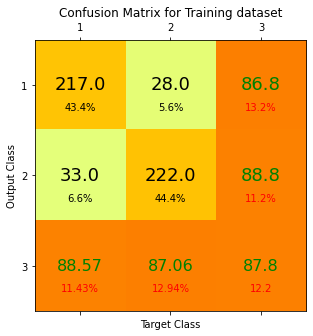

In [ ]:
conf_mat = getConfusionMatrix(preds, train_Y_3)
accuracy = getAccuracy(conf_mat)
print("Train data:")
print(accuracy)
show_conf_mat(conf_mat, "Training")

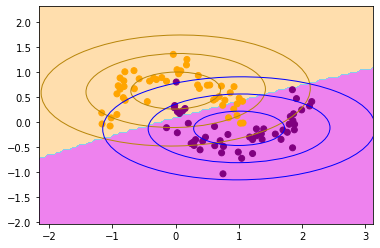

In [ ]:
preds = nbc.predict(test_X_3)
getPlotWithBoundary(test_X_3, test_Y_3, nbc, 0.05)

Test data:
86.0


<ipython-input-5-7f32514351b7>:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_label)
<ipython-input-5-7f32514351b7>:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_label)


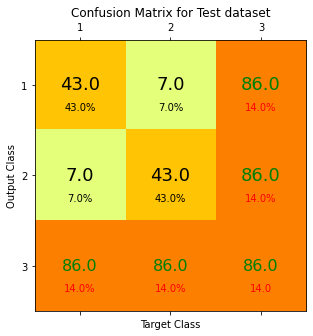

In [ ]:
conf_mat = getConfusionMatrix(preds, test_Y_3)
accuracy = getAccuracy(conf_mat)
print("Test data:")
print(accuracy)
show_conf_mat(conf_mat, "Test")